Name: Yilin Pu

Github Username: pyl32

USC ID: 2952467624

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import statsmodels.api as sm
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import normalize

### 1. An interesting task in machine learning is classification of time series. In this problem,we will classify the activities of humans based on time series obtained by a Wireless Sensor Network.
#### (a) Download the AReM data from: https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+system+based+on+Multisensor+data+fusion+\%28AReM\%29 . The dataset contains 7 folders that represent seven types of activities. In each folder, there are multiple files each of which represents an instant of a human performing an activity.1 Each file containis 6 time series collected from activities of the same person, which are called avg rss12, var rss12, avg rss13, var rss13, vg rss23, and ar rss23. There are 88 instances in the dataset, each of which contains 6 time series and each time series has 480 consecutive values.

In [4]:
data = '../data/ARem'
activities = ['bending1', 'walking', 'bending2', 'standing', 'sitting', 'lying', 'cycling']

#### (b) Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1,2, and 3 in other folders as test data and other datasets as train data.

In [5]:
train = []
test = []
for root,dirs,files in os.walk(data):
    if not dirs:
        activity = root.split('/')[3]
        for f in files:
            num = re.findall('\d+',f)[0]
            path = root + '/' + f
            if activity in ['bending1','bending2']:
                if int(num) <= 2:
                    test.append(path)
                else:
                    train.append(path)
            else:
                if int(num) <= 3:
                    test.append(path)
                else:
                    train.append(path)
# print(train)
# print(test)

#### (c) Feature Extraction Classification of time series usually needs extracting features from them. In this problem, we focus on time-domain features. 

##### i. Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).

The time-domain features are minimum, maximum, mean, median, standard deviation, quantiles, skewness, kurtosis and higher order moments.

##### ii. Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly.

In [6]:
col = ['time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
features = ['min','max','mean','median','std','1st_quartile','3rd_quartile']
total_features = [] 
i=1
for i in range(1,7):
    for feat in features:
        total_features.append(feat+str(i))
    i += 1
instances1 = []
for path in train:
    data1 = pd.read_csv(path,header=None,skiprows=[0,1,2,3,4],error_bad_lines=False, warn_bad_lines=False)
    if len(data1.iloc[6,:]) == 1:
        data1 = pd.read_csv(path, skiprows=5, header=None,sep="\s+",error_bad_lines=False, warn_bad_lines=False)
    data1.columns = col
    data_feature = data1.describe()
    instance1 = []
    for j in range(1,7):
        values = data_feature.iloc[:,j].values
        instance1.append(values[3])
        instance1.append(values[7])
        instance1.append(values[1])
        instance1.append(values[5])
        instance1.append(values[2])
        instance1.append(values[4])
        instance1.append(values[6])
    instances1.append(instance1)              
df_train = pd.DataFrame(instances1, columns=total_features)
df_train

,min1,max1,mean1,median1,std1,1st_quartile1,3rd_quartile1,min2,max2,mean2,...,std5,1st_quartile5,3rd_quartile5,min6,max6,mean6,median6,std6,1st_quartile6,3rd_quartile6
0,36.25,48.00,43.969125,44.50,1.618364,43.310,44.67,0.0,1.50,0.413125,...,3.318301,20.5000,23.7500,0.0,2.96,0.555313,0.490,0.487826,0.0000,0.830
1,37.00,48.00,43.454958,43.25,1.386098,42.500,45.00,0.0,1.58,0.378083,...,2.488862,22.2500,24.0000,0.0,5.26,0.679646,0.500,0.622534,0.4300,0.870
2,33.00,47.75,42.179813,43.50,3.670666,39.150,45.00,0.0,3.00,0.696042,...,3.849448,30.4575,36.3300,0.0,2.18,0.613521,0.500,0.524317,0.0000,1.000
3,33.00,45.75,41.678063,41.75,2.243490,41.330,42.75,0.0,2.83,0.535979,...,2.411026,28.4575,31.2500,0.0,1.79,0.383292,0.430,0.389164,0.0000,0.500
4,35.00,47.40,43.954500,44.33,1.558835,43.000,45.00,0.0,1.70,0.426250,...,1.999604,35.3625,36.5000,0.0,1.79,0.493292,0.430,0.513506,0.0000,0.940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,18.50,44.25,35.752354,36.00,4.614802,33.000,39.33,0.0,12.60,3.328104,...,3.120057,14.0000,18.0625,0.0,9.39,3.069667,2.770,1.748326,1.7975,4.060
65,24.25,45.00,37.177042,36.25,3.581301,34.500,40.25,0.0,8.58,2.374208,...,2.890347,17.9500,21.7500,0.0,9.34,2.921729,2.500,1.852600,1.5000,3.900
66,23.33,43.50,36.248768,36.75,3.824632,33.415,39.25,0.0,9.71,2.737307,...,3.617405,15.7500,21.0000,0.0,11.15,3.532463,3.110,1.965267,2.1700,4.625
67,26.25,44.25,36.957458,36.29,3.434863,34.500,40.25,0.0,8.64,2.420083,...,2.851673,14.0000,18.2500,0.0,8.34,2.934625,2.525,1.631380,1.6600,4.030


In [7]:
instances2 = []

for path in test:
    data2 = pd.read_csv(path,header=None,skiprows=[0,1,2,3,4],error_bad_lines=False, warn_bad_lines=False)
    data2.columns = col
    data_feature = data2.describe()
    instance2 = []
    for j in range(1,7):
        values = data_feature.iloc[:,j].values
        instance2.append(values[3])
        instance2.append(values[7])
        instance2.append(values[1])
        instance2.append(values[5])
        instance2.append(values[2])
        instance2.append(values[4])
        instance2.append(values[6])
    instances2.append(instance2)              
df_test = pd.DataFrame(instances2, columns=total_features)
df_test

,min1,max1,mean1,median1,std1,1st_quartile1,3rd_quartile1,min2,max2,mean2,...,std5,1st_quartile5,3rd_quartile5,min6,max6,mean6,median6,std6,1st_quartile6,3rd_quartile6
0,37.25,45.00,40.624792,40.500,1.476967,39.2500,42.0000,0.0,1.30,0.358604,...,2.188449,33.0000,36.0000,0.0,1.92,0.570583,0.430,0.582915,0.0000,1.300
1,38.00,45.67,42.812812,42.500,1.435550,42.0000,43.6700,0.0,1.22,0.372438,...,1.995255,32.0000,34.5000,0.0,3.11,0.571083,0.430,0.601010,0.0000,1.300
2,19.33,43.50,34.227771,35.500,4.889576,30.5000,37.7500,0.0,14.50,3.995729,...,3.092094,14.7500,18.6700,0.0,9.74,3.394125,3.100,1.792090,2.1050,4.425
3,12.50,45.00,33.509729,34.125,4.850923,30.5000,36.7500,0.0,13.05,4.450771,...,3.133564,14.6275,18.7500,0.0,8.96,3.378479,3.085,1.787360,2.0600,4.440
4,15.00,46.75,34.660583,35.000,5.315110,31.0000,38.2500,0.0,13.44,4.200896,...,3.155015,14.2500,18.5000,0.0,8.99,3.244396,3.000,1.630983,2.1200,4.240
5,12.75,51.00,24.562958,24.250,3.737514,23.1875,26.5000,0.0,6.87,0.590833,...,3.693786,20.5000,27.0000,0.0,4.97,0.700188,0.500,0.693720,0.4300,0.870
6,0.00,42.75,27.464604,28.000,3.583582,25.5000,30.0000,0.0,7.76,0.449708,...,5.053642,15.0000,20.7500,0.0,6.76,1.122125,0.830,1.012342,0.4700,1.300
7,33.33,48.00,44.334729,45.000,2.476940,42.2500,46.5000,0.0,3.90,0.432958,...,5.401794,9.3300,17.7500,0.0,5.02,0.933000,0.830,0.673609,0.4700,1.250
8,35.50,46.25,43.174938,43.670,1.989052,42.5000,44.5000,0.0,2.12,0.506583,...,2.983976,12.7500,16.5000,0.0,5.72,0.911979,0.830,0.666161,0.4700,1.220
9,32.75,47.00,42.760563,44.500,3.398919,41.3300,45.3725,0.0,3.34,0.486167,...,4.296574,13.0000,18.5650,0.0,5.73,0.842271,0.710,0.722165,0.4300,1.090


In [8]:
instances = instances1 + instances2
df = pd.DataFrame(instances, columns=total_features)
df.head(10)

,min1,max1,mean1,median1,std1,1st_quartile1,3rd_quartile1,min2,max2,mean2,...,std5,1st_quartile5,3rd_quartile5,min6,max6,mean6,median6,std6,1st_quartile6,3rd_quartile6
0,36.25,48.00,43.969125,44.50,1.618364,43.3100,44.6700,0.0,1.50,0.413125,...,3.318301,20.5000,23.75,0.0,2.96,0.555313,0.490,0.487826,0.000,0.8300
1,37.00,48.00,43.454958,43.25,1.386098,42.5000,45.0000,0.0,1.58,0.378083,...,2.488862,22.2500,24.00,0.0,5.26,0.679646,0.500,0.622534,0.430,0.8700
2,33.00,47.75,42.179813,43.50,3.670666,39.1500,45.0000,0.0,3.00,0.696042,...,3.849448,30.4575,36.33,0.0,2.18,0.613521,0.500,0.524317,0.000,1.0000
3,33.00,45.75,41.678063,41.75,2.243490,41.3300,42.7500,0.0,2.83,0.535979,...,2.411026,28.4575,31.25,0.0,1.79,0.383292,0.430,0.389164,0.000,0.5000
4,35.00,47.40,43.954500,44.33,1.558835,43.0000,45.0000,0.0,1.70,0.426250,...,1.999604,35.3625,36.50,0.0,1.79,0.493292,0.430,0.513506,0.000,0.9400
5,18.33,47.67,34.333042,34.75,4.948770,31.2500,38.0000,0.0,12.48,4.396958,...,3.000493,13.7500,18.00,0.0,8.01,3.261583,2.980,1.617290,2.050,4.3200
6,21.50,51.00,34.935813,35.50,4.645944,32.0000,38.0625,0.0,12.21,4.115750,...,3.192058,14.2375,18.25,0.0,10.21,3.280021,3.015,1.700918,2.120,4.5000
7,18.00,46.00,35.193333,36.00,4.751868,32.0000,38.7500,0.0,16.20,4.321021,...,3.207642,14.2500,18.50,0.0,8.50,3.241958,3.015,1.769182,1.885,4.4400
8,20.75,46.25,34.763333,35.29,4.742208,31.6700,38.2500,0.0,12.68,4.223792,...,3.174681,14.2500,18.33,0.0,9.39,3.288271,3.270,1.647528,2.050,4.3050
9,21.50,51.25,34.253521,35.00,4.940741,30.9375,37.7500,0.0,13.55,4.457896,...,3.116627,13.7500,18.00,0.0,8.32,3.500750,3.285,1.692378,2.180,4.5575


##### iii. Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.

In [9]:
f_std = df.describe().loc['std']
print(f_std)

min1             9.569975
max1             4.394362
mean1            5.335700
median1          5.440054
std1             1.772185
1st_quartile1    6.153874
3rd_quartile1    5.138925
min2             0.000000
max2             5.062729
mean2            1.574198
median2          1.412293
std2             0.884137
1st_quartile2    0.946386
3rd_quartile2    2.125399
min3             2.956462
max3             4.875137
mean3            4.008228
median3          4.036396
std3             0.946670
1st_quartile3    4.220658
3rd_quartile3    4.171628
min4             0.000000
max4             2.183625
mean4            1.166178
median4          1.145985
std4             0.458283
1st_quartile4    0.843405
3rd_quartile4    1.552504
min5             6.124001
max5             5.741238
mean5            5.675543
median5          5.813782
std5             1.024918
1st_quartile5    6.096465
3rd_quartile5    5.531720
min6             0.045838
max6             2.518921
mean6            1.154889
median6     

In [10]:
total_bootstrap = []

for i in range(1000):
    df_bootstrap = resample(df, replace=True, n_samples=df.shape[0])
    df_std_bootstrap = df_bootstrap.describe().loc['std']
    total_bootstrap.append(list(df_std_bootstrap))
total_bootstrap = pd.DataFrame(total_bootstrap, columns=total_features)

int_5, int_95 = [], []
for i in range(0,42):
    col = total_bootstrap.iloc[:,i]
    int1 = np.percentile(col, 5)
    int2 = np.percentile(col, 95)
    int_5.append(int1) 
    int_95.append(int2)
interval = [int_5,int_95]
interval_90 = pd.DataFrame(interval, columns=total_features)
print(interval_90)

        min1      max1     mean1   median1      std1  1st_quartile1  \
0   8.299610  3.310883  4.718344  4.806123  1.573346       5.566758   
1  10.801579  5.263722  5.909320  6.017694  1.949088       6.651018   

   3rd_quartile1  min2      max2     mean2  ...      std5  1st_quartile5  \
0       4.357197   0.0  4.613813  1.392237  ...  0.824790       4.732040   
1       5.848871   0.0  5.387336  1.702029  ...  1.207605       7.124199   

   3rd_quartile5      min6      max6     mean6   median6      std6  \
0       4.340598  0.000000  2.248573  1.066325  0.997765  0.480688   
1       6.464048  0.078476  2.777378  1.213844  1.147026  0.545436   

   1st_quartile6  3rd_quartile6  
0       0.687895       1.408316  
1       0.805622       1.600905  

[2 rows x 42 columns]


##### iv. Use your judgement to select the three most important time-domain features (one option may be min, mean, and max).

I choose min, max, and mean since the quantiles doesnt have much differences. The max and min can shows the range/wide of distribution, and the mean shows the average of the distribution.

### 2. Time Series Classification Part 2: Binary and Multiclass Classification


#### (a) Binary Classification Using Logistic Regression3
##### i. Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities. (See p. 129 of the textbook).

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


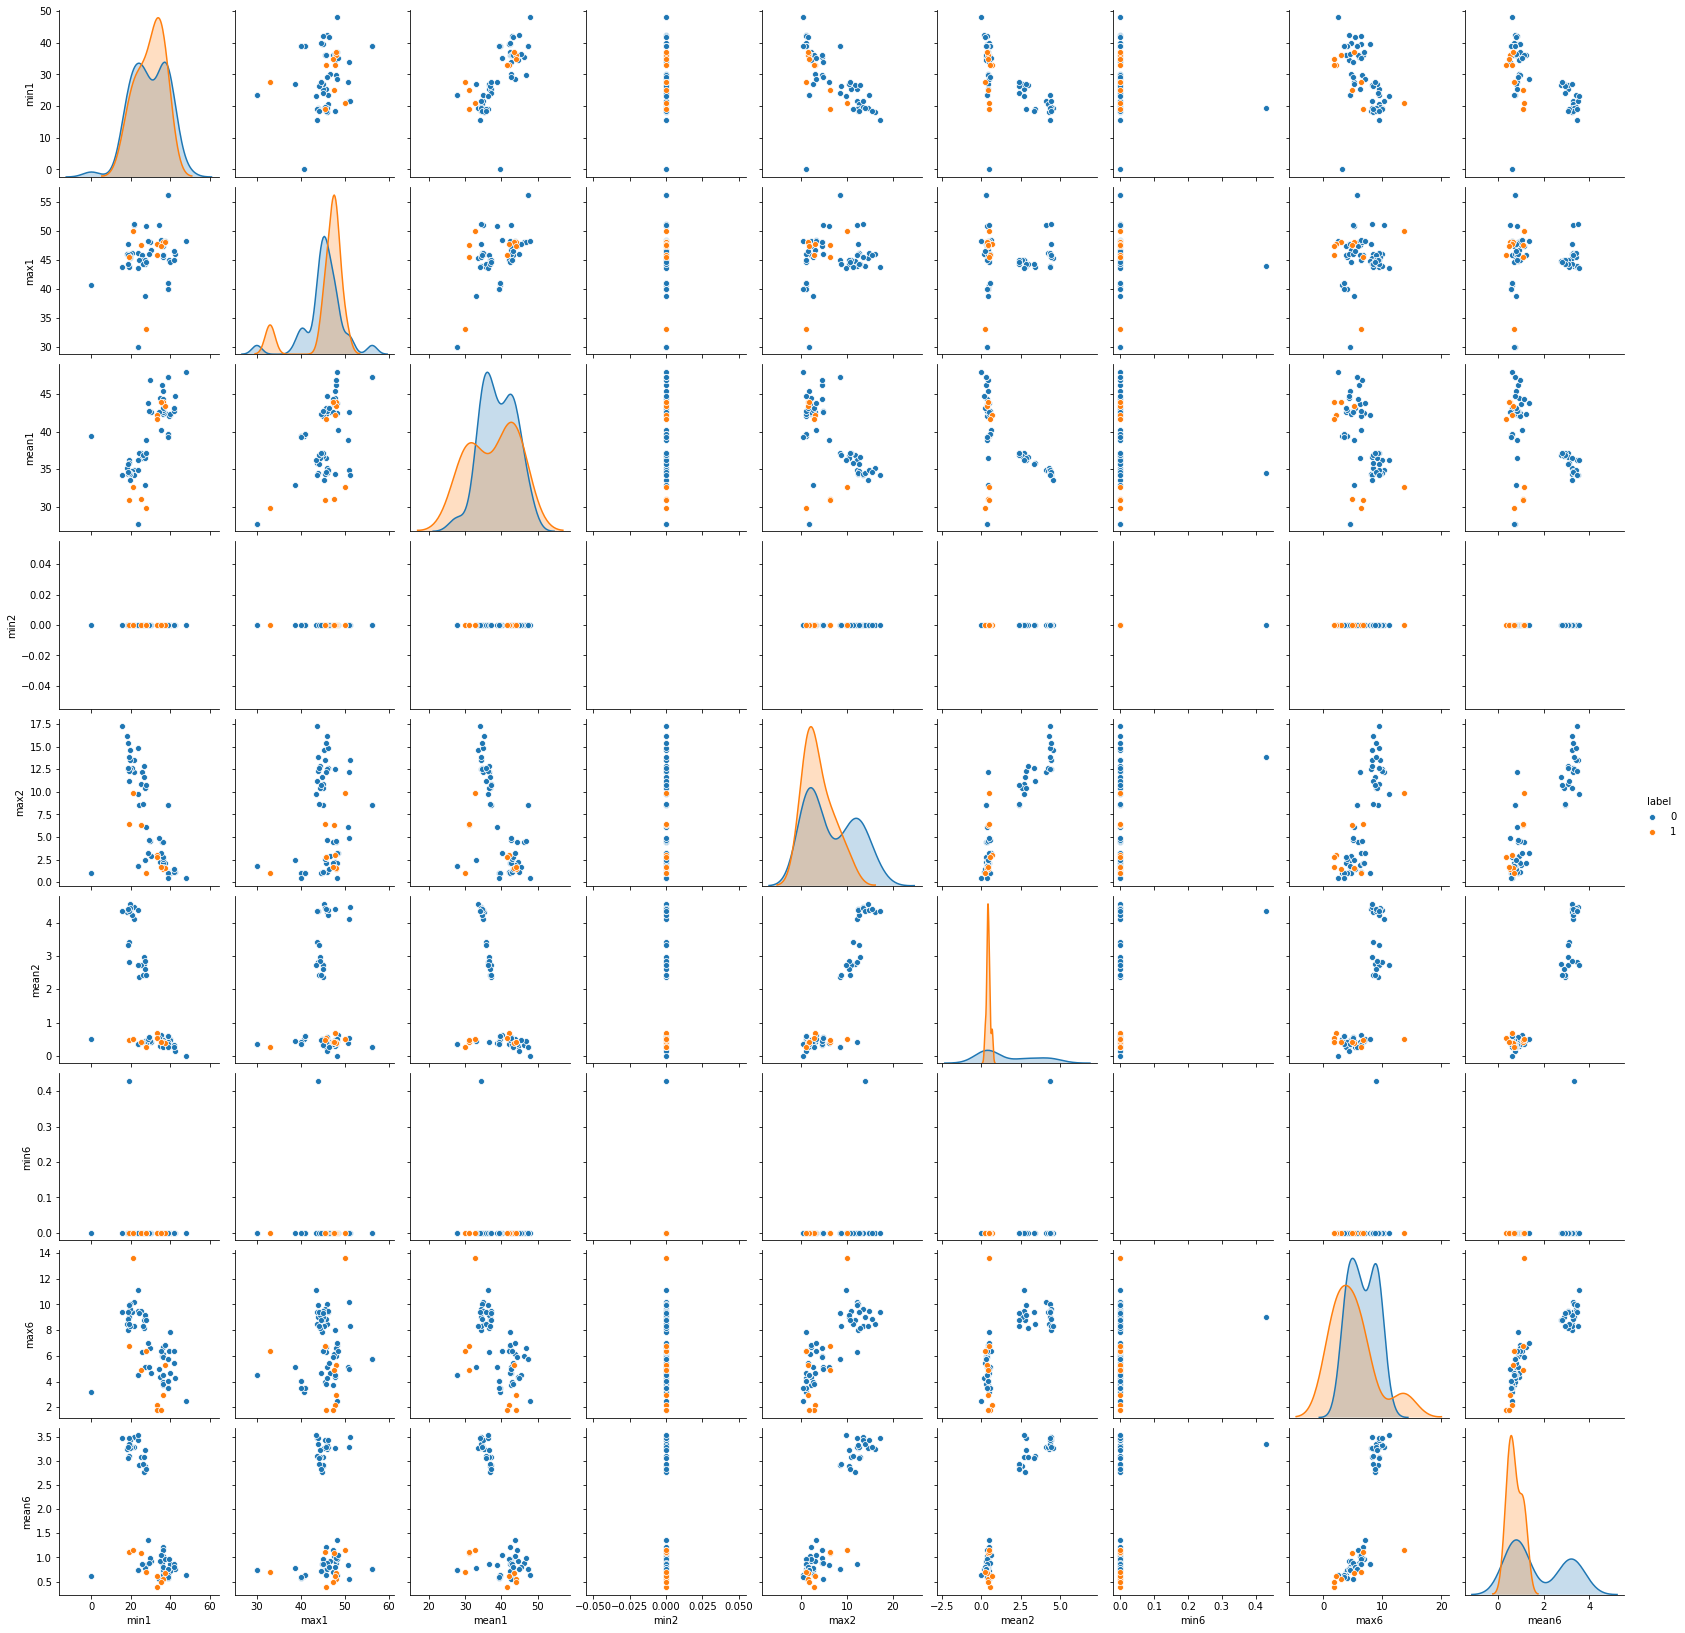

In [11]:
new_train = []
for path in train:
    name = path.split('/')[3]
    if name in ['bending1','bending2']:
        new_train.append(1)
    else:
        new_train.append(0)
new_train = pd.DataFrame(new_train)
new_train = new_train.rename(columns={0:'label'}) 
new_df_train = pd.concat([df_train,new_train],axis=1)
new_df_train
df_train126 = new_df_train[['min1','max1','mean1','min2','max2','mean2','min6','max6','mean6','label']]
sns.pairplot(df_train126, hue='label')

##### ii. Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 2(a)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. Do you see any considerable difference in the results with those of 2(a)i?

In [12]:
def f_split(x):
    col = ['time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23'] 
    features = ['min','max','mean']
    total_features = [] 
    for i in range(1,6*x+1):
        for feat in features:
            total_features.append(feat+str(i))
    instances_all = []
    for path in train:
        data1 = pd.read_csv(path,header=None,skiprows=[0,1,2,3,4],error_bad_lines=False, warn_bad_lines=False)
        if len(data1.iloc[6,:]) == 1:
            data1 = pd.read_csv(path, skiprows=5, header=None,sep="\s+",error_bad_lines=False, warn_bad_lines=False)
        data1.columns = col
        n = int(data1.shape[0]/x)
        instance1 = []
        for m in range(x):      
            data01 = data1.iloc[m*n:min((m+1)*n, data1.shape[0]),:]
            data01_feature = data01.describe()
            for j in range(1,7):
                values1 = data01_feature.iloc[:,j].values
                instance1.append(values1[3])
                instance1.append(values1[7])
                instance1.append(values1[1])
        instances_all.append(instance1)
    
    split_df_train = pd.DataFrame(instances_all, columns=total_features)
    new_split_df_train = pd.concat([split_df_train ,new_train],axis=1)

    return new_split_df_train

In [13]:
sp_df_train = f_split(2)
sp_df_train

,min1,max1,mean1,min2,max2,mean2,min3,max3,mean3,min4,...,min10,max10,mean10,min11,max11,mean11,min12,max12,mean12,label
0,36.67,45.00,43.486208,0.0,1.30,0.378667,4.00,26.33,16.397250,0.0,...,0.0,3.56,0.669750,13.75,26.00,21.882042,0.0,2.96,0.585750,1
1,39.00,48.00,44.117042,0.0,1.30,0.250042,6.25,27.00,17.744167,0.0,...,0.0,5.21,0.575708,8.00,26.00,22.850875,0.0,4.06,0.543875,1
2,33.75,47.75,43.278875,0.0,3.00,0.673292,11.00,30.00,23.141250,0.0,...,0.0,5.15,1.171792,20.00,38.50,30.965708,0.0,2.18,0.586083,1
3,33.00,45.75,41.621208,0.0,2.83,0.623083,3.00,28.25,19.081458,0.0,...,0.0,2.35,0.568667,26.00,36.00,29.635833,0.0,1.50,0.347500,1
4,36.50,46.50,44.057167,0.0,1.50,0.381042,14.25,29.25,23.096792,0.0,...,0.0,4.44,0.501167,29.00,38.25,34.883375,0.0,1.50,0.388333,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,20.00,44.25,35.692167,0.0,11.39,3.324208,5.00,27.00,16.010708,0.0,...,0.0,8.96,2.889375,7.00,24.33,16.130417,0.0,8.81,2.966917,0
65,24.25,45.00,36.954208,0.0,8.18,2.392667,5.50,26.75,17.121542,0.0,...,0.0,7.83,2.826125,11.75,24.50,19.643917,0.0,9.34,2.838083,0
66,27.00,42.67,36.337908,0.0,9.71,2.698494,9.50,28.00,18.573975,0.0,...,0.0,8.55,3.220126,8.00,26.67,18.658996,0.0,11.15,3.530669,0
67,26.25,43.40,36.865417,0.0,7.46,2.387250,7.00,26.50,15.117208,0.0,...,0.0,8.06,2.761833,2.00,21.25,16.140708,0.0,8.34,2.904458,0


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data

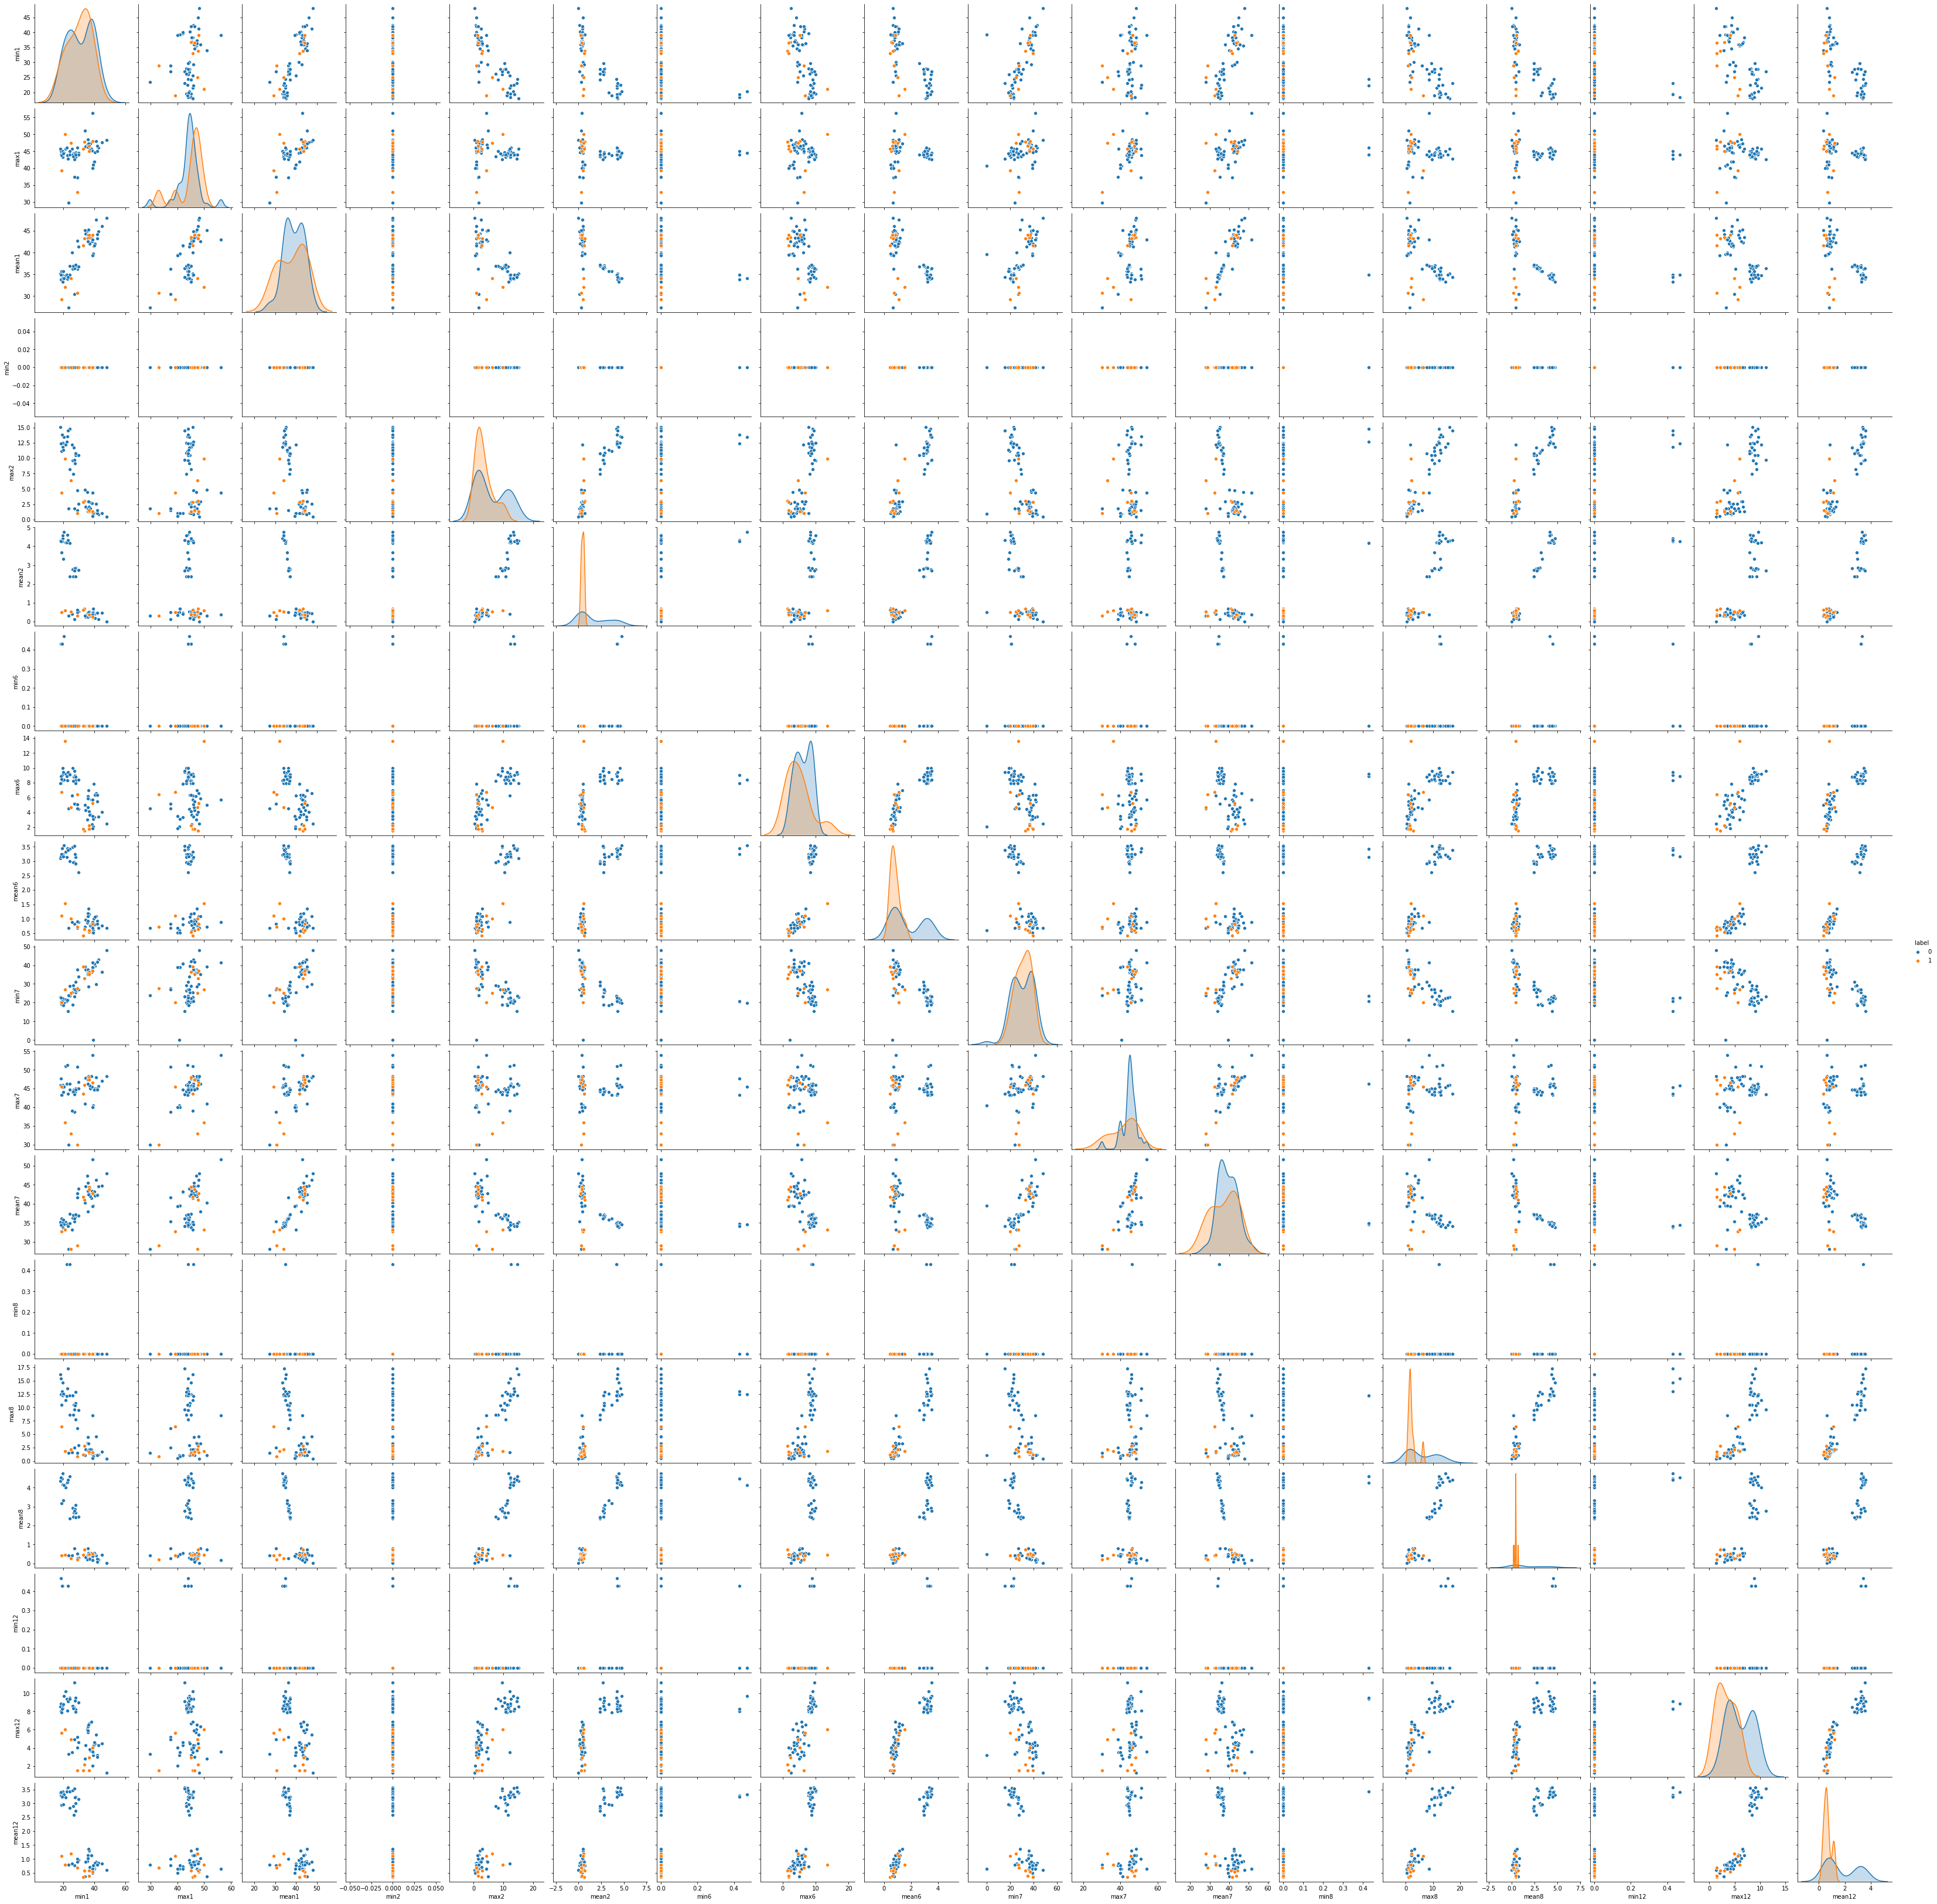

In [14]:
sp1_df_train = sp_df_train[['min1','max1','mean1','min2','max2','mean2','min6','max6','mean6','min7','max7','mean7','min8','max8','mean8','min12','max12','mean12','label']]
pairplot1 = sns.pairplot(sp1_df_train,hue='label')

##### iii. Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length and use logistic regression5 to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance. ......etc. 

In [15]:
optimal = []
scores = []
for l in range(1,21):
    total_data = f_split(l)
    train_x = total_data.iloc[:,:-1] 
    train_y = total_data.iloc[:,-1]
    model = LogisticRegression(max_iter=1500,penalty='none')
    kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=69)
    rfecv = RFECV(estimator=model,step=1,cv=kfold)
    rfecv.fit(train_x,train_y)
    optimal.append(rfecv.n_features_)
    scores.append(rfecv.grid_scores_)
    
for l in range(1,21):
    print('The best pair value is','(',l,',',optimal[l-1],')')
    print('The best score is:',scores[l-1].max())
    
total_data = f_split(l)
train_x = total_data.iloc[:,:-1]
train_y = total_data.iloc[:,-1]
model = LogisticRegression(max_iter=1500,penalty='none')
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=69)
rfecv = RFECV(estimator=model,step=1,cv=kfold)
rfecv.fit(train_x,train_y)
print(rfecv.n_features_)
print(rfecv.ranking_)

The best pair value is ( 1 , 6 )
The best score is: 1.0
The best pair value is ( 2 , 8 )
The best score is: 0.9714285714285715
The best pair value is ( 3 , 7 )
The best score is: 0.9857142857142858
The best pair value is ( 4 , 4 )
The best score is: 0.9571428571428573
The best pair value is ( 5 , 1 )
The best score is: 0.9571428571428571
The best pair value is ( 6 , 13 )
The best score is: 0.9571428571428573
The best pair value is ( 7 , 7 )
The best score is: 0.9714285714285715
The best pair value is ( 8 , 5 )
The best score is: 0.9714285714285715
The best pair value is ( 9 , 28 )
The best score is: 0.9714285714285715
The best pair value is ( 10 , 10 )
The best score is: 0.9571428571428571
The best pair value is ( 11 , 11 )
The best score is: 0.9714285714285715
The best pair value is ( 12 , 4 )
The best score is: 0.9714285714285715
The best pair value is ( 13 , 6 )
The best score is: 0.9857142857142858
The best pair value is ( 14 , 27 )
The best score is: 0.9571428571428573
The best pa

The best value of (l,p) is (1,6)


The fatures are mean1, max2, mean3, min5, max5, mean5

##### iv. Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them.

In [16]:
total_data = f_split(l)
train_x = total_data.iloc[:,:-1]
train_y = total_data.iloc[:,-1]
train_x_feat = train_x[['mean1','max2','mean3','min5','max5','mean5']]
md = LogisticRegression(max_iter=1500,penalty='none')
md.fit(train_x_feat,train_y)
train_y_pred = md.predict(train_x_feat)
confusion_mat = confusion_matrix(train_y,train_y_pred)
print('The confusion matrix of training set is:\n',confusion_mat)

score_y_train = md.predict_proba(train_x_feat)[:, 1]
fpr, tpr, thresholds = roc_curve(train_y,score_y_train)
AUC = auc(fpr, tpr)
print('The AUC of training set is:',AUC)

The confusion matrix of training set is:
 [[60  0]
 [ 0  9]]
The AUC of training set is: 1.0


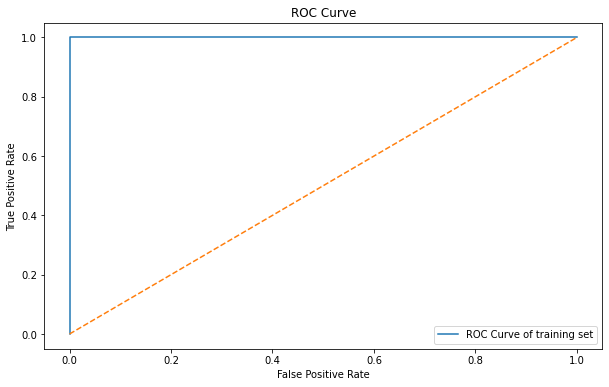

In [17]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(fpr, tpr, label="ROC Curve of training set")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.plot([0, 1], [0, 1], "--")
ax.legend()
ax.set_title("ROC Curve")
plt.show()

In [18]:
train_x_feat1 = sm.add_constant(train_x_feat)
LR_md = sm.Logit(train_y,train_x_feat1)
LR = LR_md.fit(method='bfgs')
print(LR.summary())

         Current function value: 0.000003
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                   69
Model:                          Logit   Df Residuals:                       62
Method:                           MLE   Df Model:                            6
Date:                Sun, 06 Mar 2022   Pseudo R-squ.:                   1.000
Time:                        00:58:30   Log-Likelihood:            -0.00018259
converged:                      False   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 9.589e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -25.3420        nan        nan        nan         nan         n

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


##### v. Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

In [19]:
new_test = []
for path in test:
    name = path.split('/')[3]
    if name in ['bending1','bending2']:
        new_test.append(1)
    else:
        new_test.append(0)
new_test = pd.DataFrame(new_test)
new_test = new_test.rename(columns={0:'label'}) 
        
def f_split_test(x):
    col = ['time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23'] 
    features = ['min','max','mean']
    total_features = [] 
    for i in range(1,6*x+1):
        for feat in features:
            total_features.append(feat+str(i))
    instances_all = []
    for path in test:
        data1 = pd.read_csv(path,header=None,skiprows=[0,1,2,3,4],error_bad_lines=False, warn_bad_lines=False)
        if len(data1.iloc[6,:]) == 1:
            data1 = pd.read_csv(path, skiprows=5, header=None,sep="\s+",error_bad_lines=False, warn_bad_lines=False)
        data1.columns = col
        n = int(data1.shape[0]/x)
        instance1 = []
        for m in range(x):      
            data01 = data1.iloc[m*n:min((m+1)*n, data1.shape[0]),:]
            data01_feature = data01.describe()
            for j in range(1,7):
                values1 = data01_feature.iloc[:,j].values
                instance1.append(values1[3])
                instance1.append(values1[7])
                instance1.append(values1[1])
        instances_all.append(instance1)
    
    split_df_test = pd.DataFrame(instances_all, columns=total_features)
    new_split_df_test = pd.concat([split_df_test ,new_test],axis=1)
    return new_split_df_test

The confusion matrix of test set is:
 [[15  0]
 [ 0  4]]
The AUC of test set is: 1.0


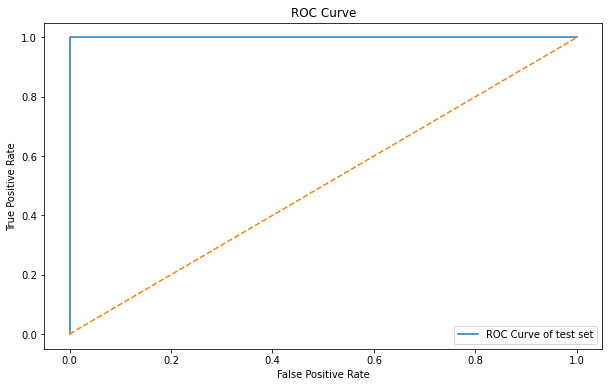

In [20]:
total_data = f_split_test(1)
test_x = total_data.iloc[:,:-1]
test_y = total_data.iloc[:,-1]
test_x_feat = test_x[['mean1','max2','mean3','min5','max5','mean5']]
md = LogisticRegression(max_iter=1000,penalty='none')
md.fit(test_x_feat,test_y)
test_y_pred = md.predict(test_x_feat)
confusion_mat = confusion_matrix(test_y,test_y_pred)
print('The confusion matrix of test set is:\n',confusion_mat)

score_y_test = md.predict_proba(test_x_feat)[:, 1]
fpr, tpr, thresholds = roc_curve(test_y,score_y_test)
AUC = auc(fpr, tpr)
print('The AUC of test set is:',AUC)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(fpr, tpr, label="ROC Curve of test set")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.plot([0, 1], [0, 1], "--")
ax.legend()
ax.set_title("ROC Curve")
plt.show()


In [21]:
print(md.score(train_x_feat, train_y))
print(md.score(test_x_feat, test_y))

0.9420289855072463
1.0


After look the results of ROC, AUC, and the confusion matrix, we can see the accuracy of test set almost same as the training test.

##### vi. Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

Yes. The results from statmodels is complete separation. In this case the Maximum Likelihood Estimator does not exist and the parameters are not identified.

##### vii. From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

Yes. From confusion matrix above, we can see that the number of non-bending class is 60 with label 0 which has significantly more sample than bending class that only 9 with label 1.
Then, build a logistic regression model base on case control sampling below

In [22]:
total_data = f_split(1)
total_data_p = total_data[['mean1','max2','mean3','min5','max5','mean5','label']]
df_1 = total_data_p[total_data_p.label==1]
df_0 = total_data_p[total_data_p.label==0]
df_t = resample(df_0,replace=True,n_samples=27,random_state=13)
df_tt = pd.concat([df_1,df_t])
train_x1 = df_tt.iloc[:,:-1]
train_y1 = df_tt.iloc[:,-1]

mdnew = LogisticRegression(max_iter=1000,penalty='none')
mdnew.fit(train_x1,train_y1)
train_y_pred2 = mdnew.predict(train_x1)
confusion_mat_train2 = confusion_matrix(train_y1,train_y_pred2)
print('The confusion matrix of training set is:\n',confusion_mat_train2)


score_y_trainn = mdnew.predict_proba(train_x1)[:, 1]
fpra, tpra, thresholdsa = roc_curve(train_y1,score_y_trainn)
AUC_trainn = auc(fpra, tpra)
print('The AUC of training set based on case-control sampling is:',AUC_trainn)



The confusion matrix of training set is:
 [[27  0]
 [ 0  9]]
The AUC of training set based on case-control sampling is: 1.0


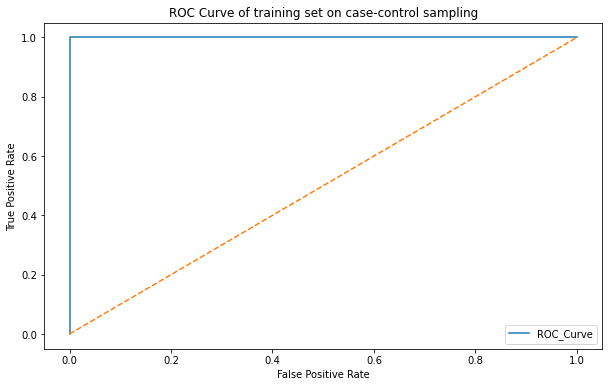

In [23]:
fig3, ax3 = plt.subplots(figsize=(10,6))
ax3.plot(fpra, tpra, label="ROC_Curve")
ax3.set_xlabel("False Positive Rate")
ax3.set_ylabel("True Positive Rate")
ax3.legend()
ax3.plot([0, 1], [0, 1], "--")
ax3.set_title("ROC Curve of training set on case-control sampling")
plt.show()

The confusion matrix from test set is:
 [[15  0]
 [ 0  4]]
The AUC of test set based on case-control sampling is: 1.0


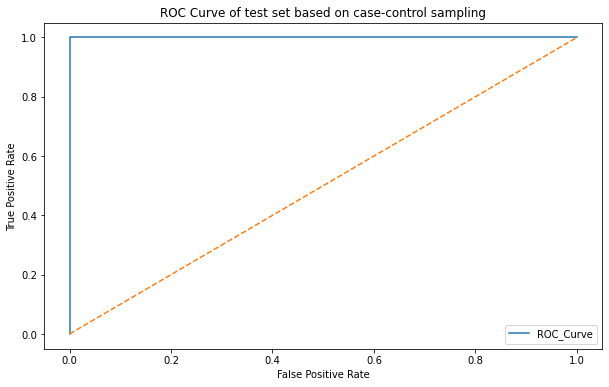

In [24]:
total_data = f_split_test(1)
test_x2 = total_data.iloc[:,:-1]
test_y2 = total_data.iloc[:,-1]
test_x_feat2 = test_x2[['mean1','max2','mean3','min5','max5','mean5']]
test_y_pred2 = mdnew.predict(test_x_feat2)
confusion_mat_test = confusion_matrix(test_y2,test_y_pred2)
print('The confusion matrix from test set is:\n',confusion_mat_test)


score_y_testn = mdnew.predict_proba(test_x_feat2)[:, 1]
fprn, tprn, thresholdsn = roc_curve(test_y2,score_y_testn)
AUC_testn = auc(fprn, tprn)
print('The AUC of test set based on case-control sampling is:',AUC_testn)

fig3, ax3 = plt.subplots(figsize=(10,6))
ax3.plot(fprn, tprn, label="ROC_Curve")
ax3.set_xlabel("False Positive Rate")
ax3.set_ylabel("True Positive Rate")
ax3.legend()
ax3.plot([0, 1], [0, 1], "--")
ax3.set_title("ROC Curve of test set based on case-control sampling")
plt.show()

#### (b) Binary Classification Using L1-penalized logistic regression
##### i. Repeat 2(a)iii using L1-penalized logistic regression,8 i.e. instead of using pvalues for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and λ, the weight of L1 penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for λ automatically.

In [27]:
testL1 = []
trainL1 = []

for l in range(1,21):
    total_data1 = f_split(l)
    train_x = total_data1.iloc[:,:-1] 
    train_y = total_data1.iloc[:,-1]
    
    total_data2 = f_split_test(l)
    test_x = total_data2.iloc[:,:-1]
    test_y = total_data2.iloc[:,-1]
    
    tr_scaler = StandardScaler()
    tr_scaler.fit(train_x)
    tran_train_x = tr_scaler.transform(train_x)
    
    ts_scaler = StandardScaler()
    ts_scaler.fit(test_x)
    tran_test_x = tr_scaler.transform(test_x)
    
    features = ['min','max','mean']
    feat = []
    
    for i in range(1,1+6*l):
        for f in features:
            feat.append(f+str(i))
    
    tran_train_x = pd.DataFrame(tran_train_x, columns = feat)
    tran_test_x = pd.DataFrame(tran_test_x, columns = feat)
    
    mdL1 = LogisticRegressionCV(max_iter=1500,penalty='l1',solver='liblinear')
    mdL1.fit(tran_train_x, train_y)
    
    tr_score = mdL1.score(tran_train_x, train_y)
    ts_score = mdL1.score(tran_test_x, test_y)
    
    trainL1.append(tr_score)
    testL1.append(ts_score)
    
for l in range(1,21):
    print("p = ",l)
    print(" the score of training set: ", trainL1[l-1])
    print(" the score of testing set: ", testL1[l-1])

p =  1
 the score of training set:  1.0
 the score of testing set:  0.9473684210526315
p =  2
 the score of training set:  1.0
 the score of testing set:  1.0
p =  3
 the score of training set:  1.0
 the score of testing set:  0.9473684210526315
p =  4
 the score of training set:  0.9710144927536232
 the score of testing set:  0.9473684210526315
p =  5
 the score of training set:  0.9710144927536232
 the score of testing set:  0.9473684210526315
p =  6
 the score of training set:  1.0
 the score of testing set:  0.9473684210526315
p =  7
 the score of training set:  1.0
 the score of testing set:  0.9473684210526315
p =  8
 the score of training set:  1.0
 the score of testing set:  0.9473684210526315
p =  9
 the score of training set:  0.9710144927536232
 the score of testing set:  0.9473684210526315
p =  10
 the score of training set:  1.0
 the score of testing set:  0.9473684210526315
p =  11
 the score of training set:  1.0
 the score of testing set:  0.9473684210526315
p =  12
 th

##### ii. Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

In [31]:
total_data1 = f_split(1)
train_x1 = total_data1.iloc[:,:-1] 
train_y1 = total_data1.iloc[:,-1]
    
total_data2 = f_split_test(1)
test_x1 = total_data2.iloc[:,:-1]
test_y1 = total_data2.iloc[:,-1]
    
tr_scaler = StandardScaler()
tr_scaler.fit(train_x1)
tran_train_x = tr_scaler.transform(train_x1)
    
ts_scaler = StandardScaler()
ts_scaler.fit(test_x1)
tran_test_x = tr_scaler.transform(test_x1)
    
features = ['min','max','mean']
feat = []
    
for i in range(1,7):
    for f in features:
        feat.append(f+str(i))
    
tran_train_x1 = pd.DataFrame(tran_train_x, columns = feat)
tran_test_x1 = pd.DataFrame(tran_test_x, columns = feat)
    
mdL1 = LogisticRegressionCV(max_iter=1500,penalty='l1',solver='liblinear')
mdL1.fit(tran_train_x, train_y1)
    
tr_score = mdL1.score(tran_train_x1, train_y1)
ts_score = mdL1.score(tran_test_x1, test_y1)

print(tr_score,ts_score)

1.0 0.9473684210526315


In [32]:
pred_y_tr = mdL1.predict(tran_train_x1)
confusion_mat1 = confusion_matrix(train_y1,pred_y_tr)
print(confusion_mat1)

pred_y_te = mdL1.predict(tran_test_x1)
confusion_mat2 = confusion_matrix(test_y1,pred_y_te)
print(confusion_mat2)

[[60  0]
 [ 0  9]]
[[15  0]
 [ 1  3]]


The AUC of training set is: 1.0


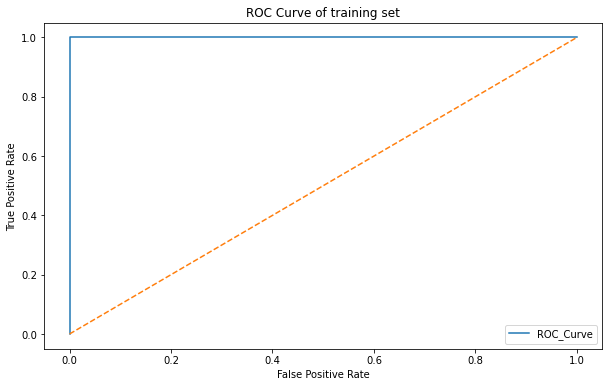

The AUC of test set is: 1.0


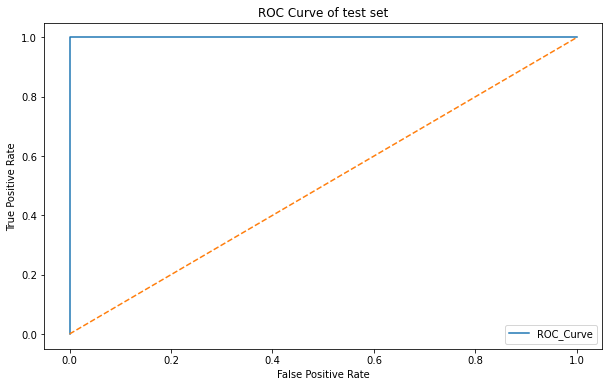

In [33]:
tr_score11 = mdL1.predict_proba(tran_train_x1)[:, 1]
fpr11, tpr11, thresholds11 = roc_curve(train_y1,tr_score11)
AUC_tr11 = auc(fpr11, tpr11)
print('The AUC of training set is:',AUC_tr11)

fig11, ax11 = plt.subplots(figsize=(10,6))
ax11.plot(fpr11, tpr11, label="ROC_Curve")
ax11.set_xlabel("False Positive Rate")
ax11.set_ylabel("True Positive Rate")
ax11.legend()
ax11.set_title("ROC Curve of training set")
ax11.plot([0, 1], [0, 1], "--")
plt.show()



tr_score22 = mdL1.predict_proba(tran_test_x1)[:, 1]
fpr22, tpr22, thresholds22 = roc_curve(test_y1,tr_score22)
AUC_tr22 = auc(fpr22, tpr22)
print('The AUC of test set is:',AUC_tr22)

fig22, ax22 = plt.subplots(figsize=(10,6))
ax22.plot(fpr22, tpr22, label="ROC_Curve")
ax22.set_xlabel("False Positive Rate")
ax22.set_ylabel("True Positive Rate")
ax22.legend()
ax22.set_title("ROC Curve of test set")
ax22.plot([0, 1], [0, 1], "--")
plt.show()

From the results of confusion matrixs, AUC, and ROC, we can conclude that L1-penalized model did not perform better than the model with vriable selection using p-values. In terms of implementation, The L1 penalized is easier to implement as compare to Variable selection with RFECV. Also computation is faster for L1 penalized as compare to Variable selection with RFECV. Backward selection with lot of features takes more time to give result. Also with backward selection we had to use max iteration which was not necessary for L1 penalized model.

#### (c) Multi-class Classification (The Realistic Case)
##### i. Find the best l in the same way as you found it in 2(b)i to build an L1-penalized multinomial regression model to classify all activities in your training set.10 Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.

In [34]:
testL1 = []
trainL1 = []

test_err = []
train_err = []

for l in range(1,21):
    total_data1 = f_split(l)
    train_x = total_data1.iloc[:,:-1] 
    train_y = total_data1.iloc[:,-1]
    
    total_data2 = f_split_test(l)
    test_x = total_data2.iloc[:,:-1]
    test_y = total_data2.iloc[:,-1]
    
    tr_scaler = StandardScaler()
    tr_scaler.fit(train_x)
    tran_train_x = tr_scaler.transform(train_x)
    
    ts_scaler = StandardScaler()
    ts_scaler.fit(test_x)
    tran_test_x = tr_scaler.transform(test_x)
    
    features = ['min','max','mean']
    feat = []
    
    for i in range(1,1+6*l):
        for f in features:
            feat.append(f+str(i))
    
    tran_train_x = pd.DataFrame(tran_train_x, columns = feat)
    tran_test_x = pd.DataFrame(tran_test_x, columns = feat)
    
    mdL1 = LogisticRegressionCV(max_iter=1500,penalty='l1',solver='saga',multi_class='multinomial')
    mdL1.fit(tran_train_x, train_y)
    
    tr_score = mdL1.score(tran_train_x, train_y)
    ts_score = mdL1.score(tran_test_x, test_y)
    
    trainL1.append(tr_score)
    testL1.append(ts_score)
    print("the score of training set: ", tr_score)
    print("the score of testing set: ", ts_score)
    
    train_e = 1 - tr_score
    test_e = 1 - ts_score
    train_err.append(train_e)
    test_err.append(test_e)
    print('The training error: ',train_e)
    print('The test error: ',test_e)

the score of training set:  1.0
the score of testing set:  0.9473684210526315
The training error:  0.0
The test error:  0.052631578947368474


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


the score of training set:  1.0
the score of testing set:  0.9473684210526315
The training error:  0.0
The test error:  0.052631578947368474
the score of training set:  1.0
the score of testing set:  0.9473684210526315
The training error:  0.0
The test error:  0.052631578947368474
the score of training set:  0.9710144927536232
the score of testing set:  0.9473684210526315
The training error:  0.02898550724637683
The test error:  0.052631578947368474


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


the score of training set:  1.0
the score of testing set:  0.9473684210526315
The training error:  0.0
The test error:  0.052631578947368474


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


the score of training set:  1.0
the score of testing set:  1.0
The training error:  0.0
The test error:  0.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

the score of training set:  1.0
the score of testing set:  0.9473684210526315
The training error:  0.0
The test error:  0.052631578947368474


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

the score of training set:  1.0
the score of testing set:  0.9473684210526315
The training error:  0.0
The test error:  0.052631578947368474


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

the score of training set:  1.0
the score of testing set:  0.9473684210526315
The training error:  0.0
The test error:  0.052631578947368474


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

the score of training set:  1.0
the score of testing set:  0.9473684210526315
The training error:  0.0
The test error:  0.052631578947368474


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

the score of training set:  1.0
the score of testing set:  0.9473684210526315
The training error:  0.0
The test error:  0.052631578947368474


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

the score of training set:  1.0
the score of testing set:  0.9473684210526315
The training error:  0.0
The test error:  0.052631578947368474


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

the score of training set:  1.0
the score of testing set:  0.9473684210526315
The training error:  0.0
The test error:  0.052631578947368474


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

the score of training set:  1.0
the score of testing set:  0.9473684210526315
The training error:  0.0
The test error:  0.052631578947368474


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

the score of training set:  0.9855072463768116
the score of testing set:  0.9473684210526315
The training error:  0.01449275362318836
The test error:  0.052631578947368474


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

the score of training set:  1.0
the score of testing set:  0.9473684210526315
The training error:  0.0
The test error:  0.052631578947368474


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

the score of training set:  1.0
the score of testing set:  0.9473684210526315
The training error:  0.0
The test error:  0.052631578947368474


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

the score of training set:  1.0
the score of testing set:  0.9473684210526315
The training error:  0.0
The test error:  0.052631578947368474


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

the score of training set:  1.0
the score of testing set:  0.9473684210526315
The training error:  0.0
The test error:  0.052631578947368474


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

the score of training set:  1.0
the score of testing set:  0.9473684210526315
The training error:  0.0
The test error:  0.052631578947368474
According to the test score and the test error the best p is  3
the test score is 0.9473684210526315
the test error is 0.052631578947368474


In [38]:
max_te_score = max(testL1)
index = 3
max_te_err = 1 - max_te_score
print('According to the test score and the test error the best p is ',index)
print('the test score is',testL1[2])
print('the test error is',test_err[2])

According to the test score and the test error the best p is  3
the test score is 0.9473684210526315
the test error is 0.052631578947368474


In [39]:
total_data_tr333 = f_split(3)
train_x333 = total_data_tr333.iloc[:,:-1] 
train_y333 = total_data_tr333.iloc[:,-1]
    
total_data_ts333 = f_split_test(3)
test_x333 = total_data_ts333.iloc[:,:-1]
test_y333 = total_data_ts333.iloc[:,-1]
    
tr_scaler333 = StandardScaler()
tr_scaler333.fit(train_x333)
tran_train_x333 = tr_scaler333.transform(train_x333)
    
ts_scaler333 = StandardScaler()
ts_scaler333.fit(test_x333)
tran_test_x333 = tr_scaler333.transform(test_x333)
    
features = ['min','max','mean']
feat = []
    
for i in range(1,19):
    for f in features:
        feat.append(f+str(i))
    
tran_train_x333 = pd.DataFrame(tran_train_x333, columns = feat)
tran_test_x333 = pd.DataFrame(tran_test_x333, columns = feat)
    
mdL1333 = LogisticRegressionCV(max_iter=1500,penalty='l1',solver='saga',multi_class='multinomial')
mdL1333.fit(tran_train_x333, train_y333)
    
tr_score333 = mdL1333.score(tran_train_x333, train_y333)
ts_score333 = mdL1333.score(tran_test_x333, test_y333)

print("the score of training set: ", tr_score333)
print("the score of testing set: ", ts_score333)

the score of training set:  1.0
the score of testing set:  0.9473684210526315


[[15  0]
 [ 1  3]]


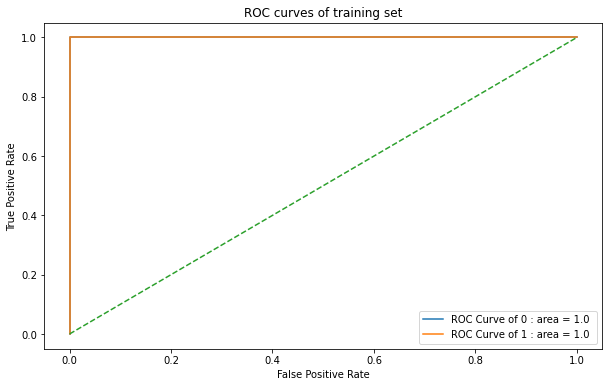

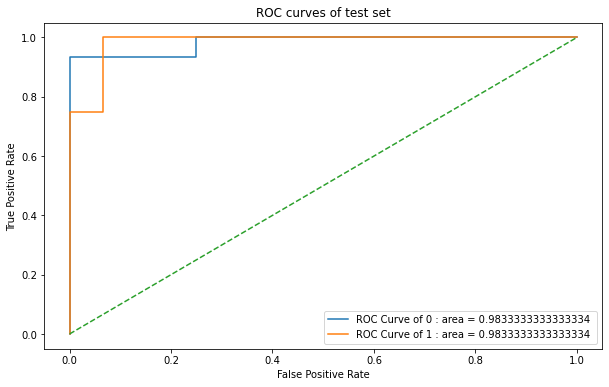

In [40]:
pred_y_te333 = mdL1333.predict(tran_test_x333)
confusion_mat333 = confusion_matrix(test_y333,pred_y_te333)
print(confusion_mat333)


fig33, axes33 = plt.subplots(figsize=(10, 6))
for i, label in enumerate(mdL1333.classes_):
    fpr33, tpr33, thresholds33 = roc_curve(train_y333, mdL1333.predict_proba(tran_train_x333)[:, i], pos_label=label)
    roc_auc33 = auc(fpr33, tpr33)
    axes33.plot(fpr33, tpr33, label="ROC Curve of {} : area = {} ".format(label, roc_auc33))
axes33.set_xlabel("False Positive Rate")
axes33.set_ylabel("True Positive Rate")
axes33.legend()
axes33.set_title("ROC curves of training set")
axes33.plot([0, 1], [0, 1], "--")
plt.show()

fig333, axes333 = plt.subplots(figsize=(10, 6))
for i, label in enumerate(mdL1333.classes_):
    fpr333, tpr333, thresholds333 = roc_curve(test_y333, mdL1333.predict_proba(tran_test_x333)[:, i], pos_label=label)
    roc_auc333 = auc(fpr333, tpr333)
    axes333.plot(fpr333, tpr333, label="ROC Curve of {} : area = {} ".format(label, roc_auc333))
axes333.set_xlabel("False Positive Rate")
axes333.set_ylabel("True Positive Rate")
axes333.legend()
axes333.set_title("ROC curves of test set")
axes333.plot([0, 1], [0, 1], "--")
plt.show()


##### ii. Repeat 2(c)i using a Na¨ıve Bayes’ classifier. Use both Gaussian and Multinomial priors and compare the results.

In [43]:
testscore = []
trainscore = []

test_err = []
train_err = []

for l in range(1,21):
    total_data1 = f_split(l)
    train_x = total_data1.iloc[:,:-1] 
    train_y = total_data1.iloc[:,-1]
    
    total_data2 = f_split_test(l)
    test_x = total_data2.iloc[:,:-1]
    test_y = total_data2.iloc[:,-1]
    
    tran_train_x = normalize(train_x)
    tran_test_x = normalize(test_x)
    
    features = ['min','max','mean']
    feat = []
    
    for i in range(1,1+6*l):
        for f in features:
            feat.append(f+str(i))
    
    tran_train_x = pd.DataFrame(tran_train_x, columns = feat)
    tran_test_x = pd.DataFrame(tran_test_x, columns = feat)
    
    mdG = GaussianNB()
    mdG.fit(tran_train_x, train_y)
    
    tr_scoreG = mdG.score(tran_train_x, train_y)
    ts_scoreG = mdG.score(tran_test_x, test_y)
    
    print("the score of training set: ", tr_scoreG)
    print("the score of testing set: ", ts_scoreG)
    trainscore.append(tr_scoreG)
    testscore.append(ts_scoreG)
    
    train_eG = 1 - tr_scoreG
    test_eG = 1 - ts_scoreG
    print('The training error: ',train_eG)
    print('The test error: ',test_eG)
    train_err.append(train_eG)
    test_err.append(test_eG)


the score of training set:  0.8695652173913043
the score of testing set:  0.8947368421052632
The training error:  0.13043478260869568
The test error:  0.10526315789473684
the score of training set:  0.5362318840579711
the score of testing set:  0.631578947368421
The training error:  0.46376811594202894
The test error:  0.368421052631579
the score of training set:  0.5217391304347826
the score of testing set:  0.631578947368421
The training error:  0.4782608695652174
The test error:  0.368421052631579
the score of training set:  0.5217391304347826
the score of testing set:  0.631578947368421
The training error:  0.4782608695652174
The test error:  0.368421052631579
the score of training set:  0.5652173913043478
the score of testing set:  0.631578947368421
The training error:  0.4347826086956522
The test error:  0.368421052631579
the score of training set:  0.5652173913043478
the score of testing set:  0.47368421052631576
The training error:  0.4347826086956522
The test error:  0.5263157

In [44]:
G_te_score = max(testscore)
index2 = testscore.index(G_te_score)
G_te_err = 1 - G_te_score
print('According to the test score and the test error the best p is ',index2)
print('the test score is', G_te_score)
print('the test error is', G_te_err)

According to the test score and the test error the best p is  0
the test score is 0.8947368421052632
the test error is 0.10526315789473684


In [46]:
total_data14 = f_split(4)
train_x4 = total_data14.iloc[:,:-1] 
train_y4 = total_data14.iloc[:,-1]
    
total_data24 = f_split_test(4)
test_x4 = total_data24.iloc[:,:-1]
test_y4 = total_data24.iloc[:,-1]
    
tran_train_x4 = normalize(train_x4)
tran_test_x4 = normalize(test_x4)
    
features = ['min','max','mean']
feat = []
    
for i in range(1,1+6*4):
    for f in features:
        feat.append(f+str(i))
    
tran_train_x4 = pd.DataFrame(tran_train_x4, columns = feat)
tran_test_x4 = pd.DataFrame(tran_test_x4, columns = feat)
    
mdG4 = GaussianNB()
mdG4.fit(tran_train_x4, train_y4)
    
tr_scoreG4 = mdG4.score(tran_train_x4, train_y4)
ts_scoreG4 = mdG4.score(tran_test_x4, test_y4)

print("the score of training set: ", tr_scoreG4)
print("the score of testing set: ", ts_scoreG4)

pred_y_tr4 = mdG4.predict(tran_train_x4)
confusion_mat4 = confusion_matrix(train_y4,pred_y_tr4)
print(confusion_mat4)

the score of training set:  0.5217391304347826
the score of testing set:  0.631578947368421
[[27 33]
 [ 0  9]]


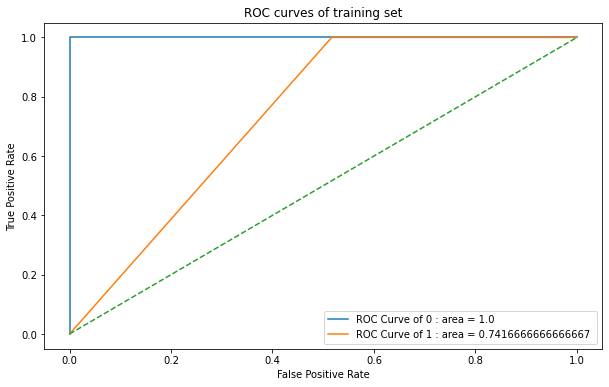

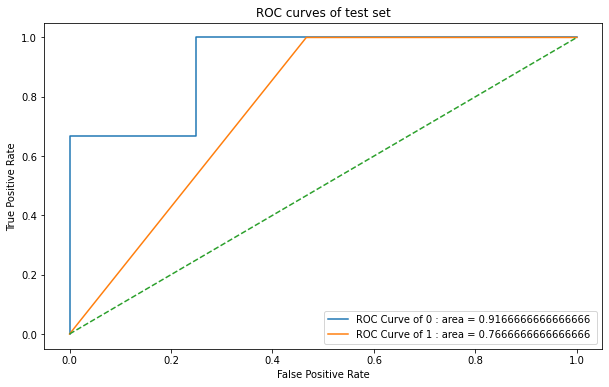

In [48]:
figGtr, axesGtr = plt.subplots(figsize=(10, 6))
for i, label in enumerate(mdG4.classes_):
    fprGtr, tprGtr, thresholdsGtr = roc_curve(train_y4, mdG4.predict_proba(tran_train_x4)[:, i], pos_label=label)
    roc_aucGtr = auc(fprGtr, tprGtr)
    axesGtr.plot(fprGtr, tprGtr, label="ROC Curve of {} : area = {} ".format(label, roc_aucGtr))
axesGtr.set_xlabel("False Positive Rate")
axesGtr.set_ylabel("True Positive Rate")
axesGtr.legend()
axesGtr.plot([0, 1], [0, 1], "--")
axesGtr.set_title("ROC curves of training set")
plt.show()


figGtr, axesGtr = plt.subplots(figsize=(10, 6))
for i, label in enumerate(mdG4.classes_):
    fprGtr, tprGtr, thresholdsGtr = roc_curve(test_y4, mdG4.predict_proba(tran_test_x4)[:, i], pos_label=label)
    roc_aucGtr = auc(fprGtr, tprGtr)
    axesGtr.plot(fprGtr, tprGtr, label="ROC Curve of {} : area = {} ".format(label, roc_aucGtr))
axesGtr.set_xlabel("False Positive Rate")
axesGtr.set_ylabel("True Positive Rate")
axesGtr.legend()
axesGtr.plot([0, 1], [0, 1], "--")
axesGtr.set_title("ROC curves of test set")
plt.show()

In [52]:
testscorenm = []
trainscorenm = []

test_errnm = []
train_errnm = []

for l in range(1,21):
    total_data1nm = f_split(l)
    train_xnm = total_data1nm.iloc[:,:-1] 
    train_ynm = total_data1nm.iloc[:,-1]
    
    total_data2nm = f_split_test(l)
    test_xnm = total_data2nm.iloc[:,:-1]
    test_ynm = total_data2nm.iloc[:,-1]
    
    tran_train_xnm = normalize(train_xnm)
    tran_test_xnm = normalize(test_xnm)
    
    features = ['min','max','mean']
    feat = []
    
    for i in range(1,1+6*l):
        for f in features:
            feat.append(f+str(i))
    
    tran_train_xnm = pd.DataFrame(tran_train_xnm, columns = feat)
    tran_test_xnm = pd.DataFrame(tran_test_xnm, columns = feat)
    
    mdnm = MultinomialNB()
    mdnm.fit(tran_train_xnm, train_ynm)
    
    tr_scorenm = mdnm.score(tran_train_xnm, train_ynm)
    ts_scorenm = mdnm.score(tran_test_xnm, test_ynm)
    
    print("the score of training set: ", tr_scorenm)
    print("the score of testing set: ", ts_scorenm)
    trainscorenm.append(tr_scorenm)
    testscorenm.append(ts_scorenm)
    
    train_enm = 1 - tr_scorenm
    test_enm = 1 - ts_scorenm
    print('The training error: ',train_enm)
    print('The test error: ',test_enm)
    train_errnm.append(train_enm)
    test_errnm.append(test_enm)


the score of training set:  0.8695652173913043
the score of testing set:  0.7894736842105263
The training error:  0.13043478260869568
The test error:  0.21052631578947367
the score of training set:  0.8695652173913043
the score of testing set:  0.7894736842105263
The training error:  0.13043478260869568
The test error:  0.21052631578947367
the score of training set:  0.8695652173913043
the score of testing set:  0.7894736842105263
The training error:  0.13043478260869568
The test error:  0.21052631578947367
the score of training set:  0.8695652173913043
the score of testing set:  0.7894736842105263
The training error:  0.13043478260869568
The test error:  0.21052631578947367
the score of training set:  0.8695652173913043
the score of testing set:  0.7894736842105263
The training error:  0.13043478260869568
The test error:  0.21052631578947367
the score of training set:  0.8695652173913043
the score of testing set:  0.7894736842105263
The training error:  0.13043478260869568
The test er

In [54]:
nm_te_score = max(testscorenm)
indexnm = testscorenm.index(nm_te_score)
nm_te_err = 1 - nm_te_score
print('According to the test score and the test error the best p is ',indexnm)
print('the test score is', nm_te_score)
print('the test error is', nm_te_err)

According to the test score and the test error the best p is  0
the test score is 0.7894736842105263
the test error is 0.21052631578947367


In [56]:
total_data1nm = f_split(1)
train_xnm = total_data1nm.iloc[:,:-1] 
train_ynm = total_data1nm.iloc[:,-1]
    
total_data2nm = f_split_test(1)
test_xnm = total_data2nm.iloc[:,:-1]
test_ynm = total_data2nm.iloc[:,-1]
    
tran_train_xnm = normalize(train_xnm)
tran_test_xnm = normalize(test_xnm)
    
features = ['min','max','mean']
feat = []
    
for i in range(1,7):
    for f in features:
        feat.append(f+str(i))
    
tran_train_xnm = pd.DataFrame(tran_train_xnm, columns = feat)
tran_test_xnm = pd.DataFrame(tran_test_xnm, columns = feat)
    
mdnm = MultinomialNB()
mdnm.fit(tran_train_xnm, train_ynm)
    
tr_scorenm = mdnm.score(tran_train_xnm, train_ynm)
ts_scorenm = mdnm.score(tran_test_xnm, test_ynm)
    
print("the score of training set: ", tr_scorenm)
print("the score of testing set: ", ts_scorenm)
trainscorenm.append(tr_scorenm)
testscorenm.append(ts_scorenm)

the score of training set:  0.8695652173913043
the score of testing set:  0.7894736842105263


[[60  0]
 [ 9  0]]


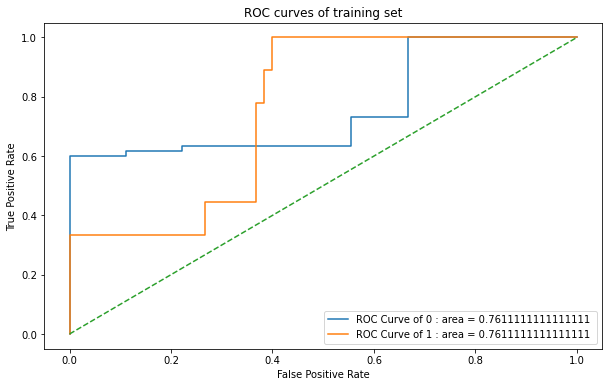

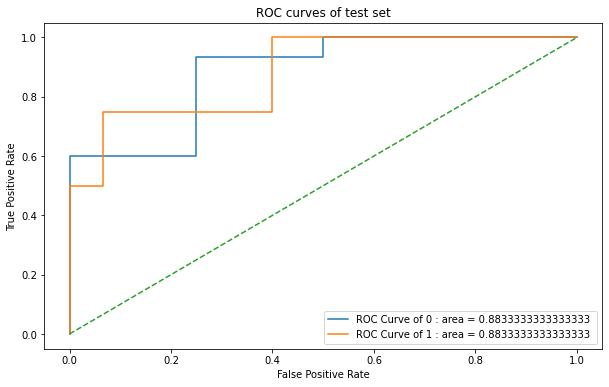

In [58]:
pred_y_trnm = mdnm.predict(tran_train_xnm)
confusion_matnm = confusion_matrix(train_ynm,pred_y_trnm)
print(confusion_matnm)


fignm1, axesnm1 = plt.subplots(figsize=(10, 6))
for i, label in enumerate(mdnm.classes_):
    fprnm1, tprnm1, thresholdsnm1 = roc_curve(train_ynm, mdnm.predict_proba(tran_train_xnm)[:, i], pos_label=label)
    roc_aucnm1 = auc(fprnm1, tprnm1)
    axesnm1.plot(fprnm1, tprnm1, label="ROC Curve of {} : area = {} ".format(label, roc_aucnm1))
axesnm1.set_xlabel("False Positive Rate")
axesnm1.set_ylabel("True Positive Rate")
axesnm1.legend()
axesnm1.plot([0, 1], [0, 1], "--")
axesnm1.set_title("ROC curves of training set")
plt.show()


fignm2, axesnm2 = plt.subplots(figsize=(10, 6))
for i, label in enumerate(mdnm.classes_):
    fprnm2, tprnm2, thresholdsnm2 = roc_curve(test_ynm, mdnm.predict_proba(tran_test_xnm)[:, i], pos_label=label)
    roc_aucnm2 = auc(fprnm2, tprnm2)
    axesnm2.plot(fprnm2, tprnm2, label="ROC Curve of {} : area = {} ".format(label, roc_aucnm2))
axesnm2.set_xlabel("False Positive Rate")
axesnm2.set_ylabel("True Positive Rate")
axesnm2.legend()
axesnm2.plot([0, 1], [0, 1], "--")
axesnm2.set_title("ROC curves of test set")
plt.show()

#### iii. Which method is better for multi-class classification in this problem?

Based on the results shown above, we can conclude that both the logistic regression model and the Gaussian Naive Bayes model have good performance. Furthermore, the logistic regression model perform slightly better than the Gaussian Naive Bayes model.

### ISLR, 4.8.3 and  4.8.7

![](../data/3,7.jpg)

### References

https://docs.python.org/3/library/os.html?highlight=walk#os.walk

https://stats.stackexchange.com/questions/50807/features-for-time-series-classification

https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html

https://www.statsmodels.org/stable/index.html